In [1]:
import json
import pandas as pd
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
DATA_FILES = [
    'ITiCSE18.json', 
    'ITiCSE19.json', 
    'ITiCSE20.json', 
    'SIGCSE18.json', 
    'SIGCSE19.json', 
    'SIGCSE20.json',
    'FIE18.json', 
    'FIE19.json',
]

In [3]:
# Load data
author_affiliations = {}
all_papers = []
for filename in DATA_FILES:
    with open(filename) as f:
        papers = json.load(f)
    for paper in papers:
        authors = []
        affiliations = []
        for author in paper['authors']:
            # TODO check if any author changed affiliations. Yep, that happens...
            name = author['name']
            affiliation = author['affiliation']
            author_affiliations[name] = affiliation
            authors.append(name)
            affiliations.append(affiliation)
        paper['authors'] = authors
        paper['affiliations'] = affiliations
        paper['venue'] = os.path.splitext(os.path.basename(filename))[0]
        all_papers.append(paper)
papers = pd.DataFrame(all_papers)
papers.head()

,title,link,abstract,authors,tags,affiliations,venue
0,Dancing rainbots: computing education with gir...,https://dl.acm.org/doi/10.1145/3197091.3211885,"We want women and girls to participate, thrive...",[Judy Robertson],"[barriers, inclusion, Women in computing]","[University of Edinburgh, UK]",ITiCSE18
1,A new era towards more engaging and human-like...,https://dl.acm.org/doi/10.1145/3197091.3211886,Engagement of learners in computer-based tutor...,[Maria Virvou],"[personalisation, artificial intelligence, Com...","[University of Piraeus, Greece]",ITiCSE18
2,Improving complex task performance using a seq...,https://dl.acm.org/doi/10.1145/3197091.3197141,Online coding tools are an increasingly common...,"[Andrew Luxton-Reilly, Michelle Craig, Paul De...","[assessment, compound assessment, novice progr...","[University of Auckland, New Zealand, Universi...",ITiCSE18
3,Syntax error based quantification of the learn...,https://dl.acm.org/doi/10.1145/3197091.3197121,Recent data-driven research has produced metri...,"[Luke Mathieson, Alireza Ahadi, Raymond Lister]","[programming, student mistakes, syntactic erro...","[University of Technology Sydney, Australia, U...",ITiCSE18
4,Programming: predicting student success early ...,https://dl.acm.org/doi/10.1145/3197091.3197101,"This paper describes a large, multi-institutio...","[Keith Quille, Susan Bergin]","[CS1, Programming, Predictors, Success, Comput...","[Institute of Technology Tallaght, Ireland / M...",ITiCSE18


In [4]:
# Define functions
def find_keywords(keywords):
    def find(row):
        search_str = row.title.lower() + row.abstract.lower() + ''.join(t.lower() for t in row.tags)
        for word in keywords:
            if word in search_str:
                return 1
        return 0
    return find

def papers_with_keywords_percent(papers, keywords):
    found = papers.apply(find_keywords(keywords), axis=1).sum()
    return 100 * found / len(papers)

def sort_by_occurrence(values, decreasing=True):
    c = Counter(values)
    return sorted(((count, v) for v, count in c.items()), reverse=decreasing)

# Papers related to automated feedback

In [5]:
search_keywords = [
    ['automatic', 'automated'],
    ['project'],
]
for keywords in search_keywords:
    print(f'{papers_with_keywords_percent(papers, keywords):.2f}% of the papers include the keywords: {", ".join(keywords)}')

5.34% of the papers include the keywords: automatic, automated
21.85% of the papers include the keywords: project


# Common Author Tags

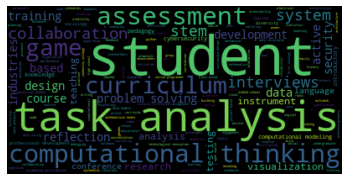

In [10]:
ignore = ['programming', 'education', 'learning', 'computer', 'science', 'computing', 'student', 'cs1', 'tool', 'cs', 'engineering', 'software', 'tools', 'profession', 'student']
all_tags = ' '.join(t.lower() for t in papers.tags.sum())
all_tags = ' '.join(w for w in all_tags.split() if w not in ignore)
wordcloud = WordCloud().generate(all_tags)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
pass

In [11]:
all_tags = [t.lower() for t in papers.tags.sum()]
for count, tag in sort_by_occurrence(all_tags):
    if count > 20:
        print(f'{tag} ({count} publications)')

education (372 publications)
tools (203 publications)
computer science education (154 publications)
computer science (132 publications)
cs1 (120 publications)
task analysis (119 publications)
programming (107 publications)
engineering profession (105 publications)
engineering education (105 publications)
programming profession (104 publications)
computational thinking (104 publications)
engineering students (100 publications)
software (86 publications)
collaboration (85 publications)
stem (81 publications)
interviews (81 publications)
industries (67 publications)
assessment (67 publications)
active learning (65 publications)
training (61 publications)
reflection (61 publications)
problem-solving (61 publications)
computational modeling (61 publications)
instruments (59 publications)
conferences (59 publications)
computing education (59 publications)
games (58 publications)
sociology (54 publications)
visualization (52 publications)
technological innovation (52 publications)
software en

In [12]:
def filter_tags_by_year(row):
    tags = row.tags
    year = int(row.venue[-2:]) + 2000
    return [{'year': year, 'tag': tag.lower()} for tag in tags]

tags_by_year = pd.DataFrame(papers.apply(filter_tags_by_year, axis=1).sum())
tag_counts = tags_by_year.groupby('tag').count()
popular_tags = list(tag_counts[tag_counts.year > 10].index)
tags_by_year = tags_by_year[tags_by_year.tag.isin(popular_tags)]
tags_by_year.groupby(['tag', 'year']).year.count().unstack().fillna(0)

year,2018,2019,2020
tag,,,
,13.0,20.0,0.0
accessibility,6.0,9.0,10.0
accreditation,9.0,8.0,2.0
active learning,31.0,18.0,16.0
adaptation models,13.0,4.0,0.0
algorithms,10.0,3.0,1.0
analysis of variance,8.0,5.0,0.0
analytical models,14.0,16.0,0.0
art,7.0,11.0,0.0


# Authors

In [13]:
for count, name in sort_by_occurrence(papers.authors.sum()):
    if count > 5:
        print(f'{name} ({count} publications)') 

Brett A. Becker (20 publications)
Tiffany Barnes (19 publications)
Monica M. McGill (19 publications)
Leo Porter (19 publications)
Kristy Elizabeth Boyer (19 publications)
Christina Gardner-McCune (16 publications)
Arto Hellas (16 publications)
Adrienne Decker (16 publications)
Allison Godwin (15 publications)
Roberto A. Bittencourt (14 publications)
Colleen M. Lewis (14 publications)
Nicholas Lytle (13 publications)
Mohsen Dorodchi (13 publications)
Diana Franklin (13 publications)
S. Monisha Pulimood (12 publications)
Dan Garcia (12 publications)
Cynthia Taylor (12 publications)
Andrew Petersen (12 publications)
Robert M. Capraro (10 publications)
Richard E. Ladner (10 publications)
Regina Barwaldt (10 publications)
Matthew Peveler (10 publications)
Lina Battestilli (10 publications)
Leigh Ann DeLyser (10 publications)
Juho Leinonen (10 publications)
Evan Maicus (10 publications)
Eric Wiebe (10 publications)
Clifford A. Shaffer (10 publications)
Barbara Cutler (10 publications)
Ankur